### Set-up

In [1]:
import argparse
import os
import cv2
import numpy as np
import torch
from PIL import Image
from easydict import EasyDict as edict
from hybrik.models import builder
from hybrik.utils.config import update_config
from hybrik.utils.presets import SimpleTransform3DSMPL
from hybrik.utils.render import SMPLRenderer
from hybrik.utils.functions import train, validate
from hybrik.utils.logger import create_logger
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from hybrik.models.PoolAttnHR_Pose import PoolAttnHR_Pose
from hybrik.models.pool.poolattnformer_HR import load_pretrained_weights
from hybrik.datasets.coco import *
from hybrik.datasets.cocoHand import COCOHandDataset
from hybrik.datasets.freiHand import FreiHAND
from torch.utils.data import Dataset, DataLoader
from hybrik.utils.loss import JointsMSELoss
from hybrik.utils.inference import get_max_preds

/home/jinxu/miniconda3/envs/hybrik_potter/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### POTTER body pose model

In [60]:
cfg_file = './configs/coco/potter_pose.yaml'
CKPT = './eval/potter_demo.pth'
cfg = update_config(cfg_file)
gpus = [int(i) for i in cfg.GPUS.split(',')]

def load_pretrained_weights(model, checkpoint):
    import collections
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint
    model_dict = model.state_dict()
    new_state_dict = collections.OrderedDict()
    matched_layers, discarded_layers = [], []
    for k, v in state_dict.items():
        # If the pretrained state_dict was saved as nn.DataParallel,
        # keys would contain "module.", which should be ignored.
        if k.startswith('module.'):
            k = k[7:]
        if k.startswith('backbone.'):
            k = k[9:]
        if k in model_dict and model_dict[k].size() == v.size():
            new_state_dict[k] = v
            matched_layers.append(k)
        else:
            discarded_layers.append(k)
    # new_state_dict.requires_grad = False
    model_dict.update(new_state_dict)

    model.load_state_dict(model_dict)
    print('load_weight', len(matched_layers))


############ MODEL ###########
# Define model
model = PoolAttnHR_Pose(**cfg.MODEL)
HMR_ckpt = torch.load(CKPT)
load_pretrained_weights(model, HMR_ckpt)

load_weight 402


#### COCO Body Dataset

In [19]:
cfg_file = 'configs/coco/potter_pose_cocoBody.yaml'
cfg = update_config(cfg_file)

######## DATASET ###########
# Load training dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_dataset = COCODataset(
    cfg,
    cfg.DATASET.ROOT,
    cfg.DATASET.TRAIN_SET,
    True,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)
# Load validation dataset
valid_dataset = COCODataset(
    cfg,
    cfg.DATASET.ROOT,
    cfg.DATASET.TEST_SET,
    False,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=cfg.TEST.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=True
)

loading annotations into memory...
Done (t=6.94s)
creating index...
index created!
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [5]:
# Cases when one image have more than one annotation (e.g. multi-persons)
multi_ann_imgs_train = {}
for i in range(len(train_dataset)):
    # Train
    img_name = train_dataset.db[i]['image'].split('/')[-1].split('.')[0]
    if img_name not in multi_ann_imgs_train:
        multi_ann_imgs_train[img_name] = 1
    else:
        multi_ann_imgs_train[img_name] += 1
print('# of unique valid images in training: ', len(multi_ann_imgs_train))

ann_cnt = 0
for k in multi_ann_imgs_train:
    ann_cnt += multi_ann_imgs_train[k]
print('Total number of annotations in training: ', ann_cnt)

# of unique valid images in training:  56599
Total number of annotations in training:  149813


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


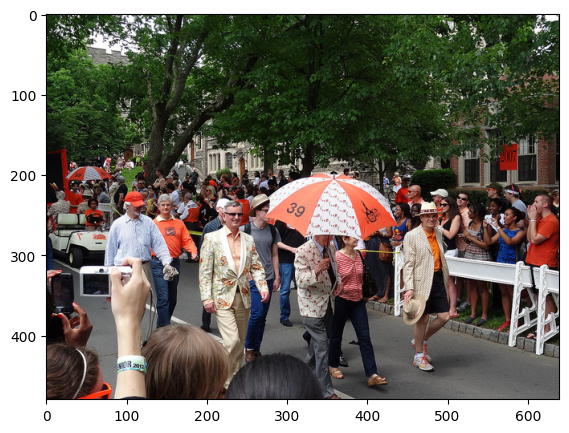

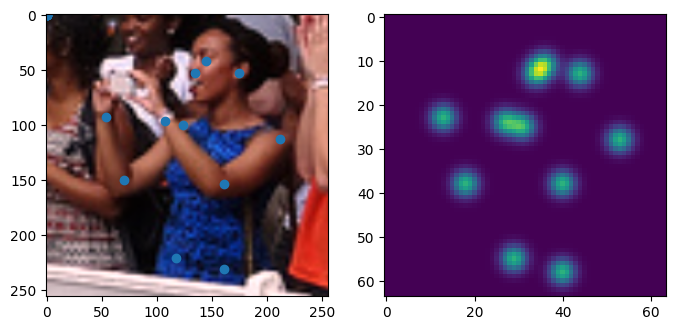

In [13]:
# Load in sample images
rand_idx = 301
input, target, target_weight, meta = train_dataset[rand_idx]

# Untransform
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

# Original image
plt.figure(figsize=(10,5))
orig_img = np.array(Image.open(meta['image']))
plt.imshow(orig_img)

# Visualization
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
vis_input = inv_normalize(input).permute(1,2,0).numpy()[:,:,::-1]
plt.imshow(vis_input)
plt.scatter(meta['joints'][:,0], meta['joints'][:,1])

plt.subplot(1,2,2)
plt.imshow(target.sum(0))

### POTTER hand pose model

Load pretrained `POTTER-cls` weight if no other pretrained hand pose weights are available; otherwise load in the pretrained hand pose weight.

In [ ]:
cfg_file = './configs/freihand/potter_pose_freihand.yaml'
CLS_CKPT = './eval/cls_s12.pth'
pretrained_hand_pose_CKPT = 'output/freihand/PoolAttnHRCam_Pose/potter_pose_freihand_chunk=3/POTTER-HandPose-freiHand.pt'
cfg = update_config(cfg_file)

# Load pretrained model
model = PoolAttnHR_Pose(**cfg.MODEL)
if pretrained_hand_pose_CKPT:
    load_pretrained_weights(model, torch.load(pretrained_hand_pose_CKPT))
    print('Loaded pretrained hand pose estimation weight')
else:
    load_pretrained_weights(model.poolattnformer_pose.poolattn_cls, torch.load(CLS_CKPT))
    print('Load POTTER-cls weight')
model.eval()

#### FreiHand Dataset

In [9]:
cfg_file = './configs/freihand/potter_pose_freihand.yaml'
cfg = update_config(cfg_file)

# Load dataset
frei_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3950, 0.4323, 0.2954],
                         std=[0.1964, 0.1734, 0.1831])
])
inv_normalize = transforms.Normalize(mean=[-0.3950/0.1964, -0.4323/0.1734, -0.2954/0.1831],
                                     std=[1/0.1964, 1/0.1734, 1/0.1831])

# Load dataset
# train_dataset = FreiHAND(config=cfg, 
#                          set_type="train", 
#                          transform=data_transform,
#                          chunk=2)
val_dataset = FreiHAND(config=cfg, 
                       set_type="val", 
                       transform=frei_transform,
                       chunk=3)
print(f'Val: {len(val_dataset)}')

Val: 9768


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


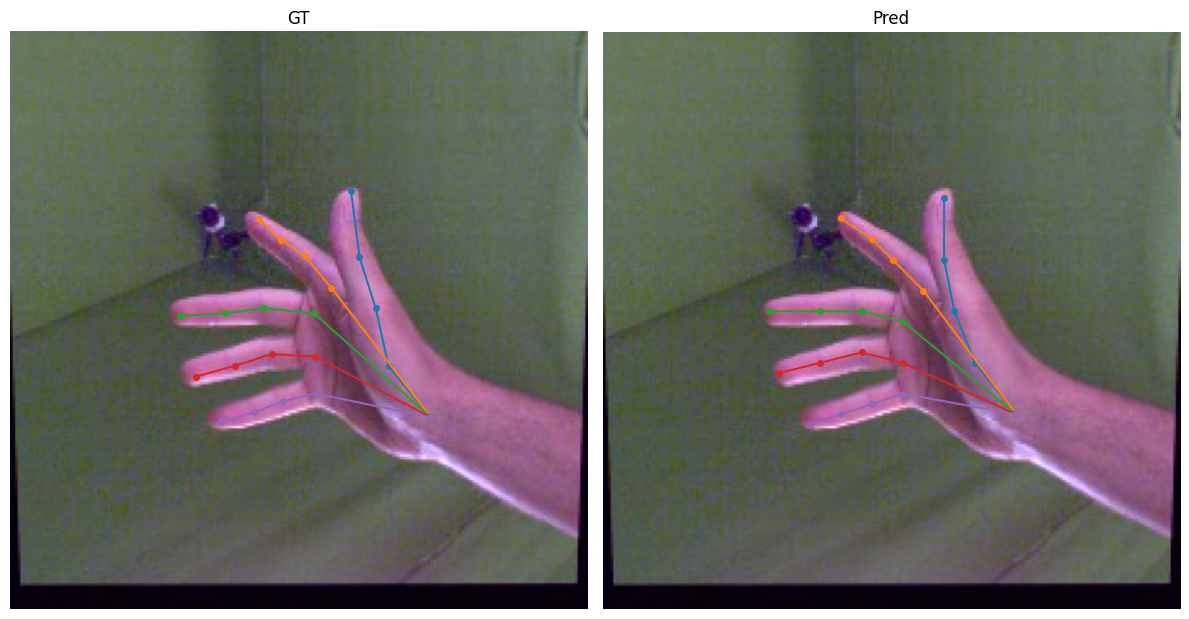

In [58]:
# DEMO
rand_idx = 340
input, kpts, target = val_dataset[rand_idx]
hand_index = np.array([[0,1,2,3,4],
                        [0,5,6,7,8],
                        [0,9,10,11,12],
                        [0,13,14,15,16],
                        [0,17,18,19,20]])

vis_input = inv_normalize(input).permute(1,2,0)
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(vis_input);
for finger_index in hand_index:
    curr_finger_kpts = kpts[finger_index]
    plt.plot(curr_finger_kpts[:,0], curr_finger_kpts[:,1], marker='o', markersize=4)
plt.title('GT')
plt.axis('off')

# Inference
output = model(input.unsqueeze(0))
preds, _ = get_max_preds(output.detach().cpu().numpy())
pred_kpts = preds.squeeze() * 4
plt.subplot(1,2,2)
plt.imshow(vis_input);
for finger_index in hand_index:
    curr_finger_kpts = pred_kpts[finger_index]
    plt.plot(curr_finger_kpts[:,0], curr_finger_kpts[:,1], marker='o', markersize=4)
plt.title('Pred')
plt.axis('off')

plt.tight_layout()

#### COCO Wholebody-Hand Dataset

In [2]:
cfg_file = './configs/coco/potter_pose_cocoHand.yaml'
config = update_config(cfg_file)

# Untransform
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

# Load dataset (omitted train dataset)
coco_tran = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
valid_dataset = COCOHandDataset(
        config,
        config.DATASET.ROOT,
        config.DATASET.TEST_SET,
        is_train=False,
        pixel_std=100,
        # transform=coco_tran,
    )

# train_dataset = COCOHandDataset(
#         config,
#         config.DATASET.ROOT,
#         config.DATASET.TRAIN_SET,
#         is_train=True,
#         pixel_std=100,
#     )

print(f"Val: {len(valid_dataset)}")

loading annotations into memory...
Done (t=1.11s)
creating index...
index created!
Val: 6538


(224, 224, 3)


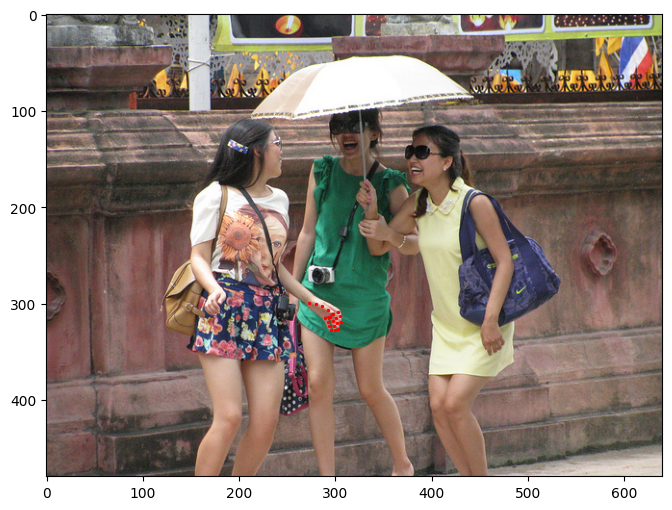

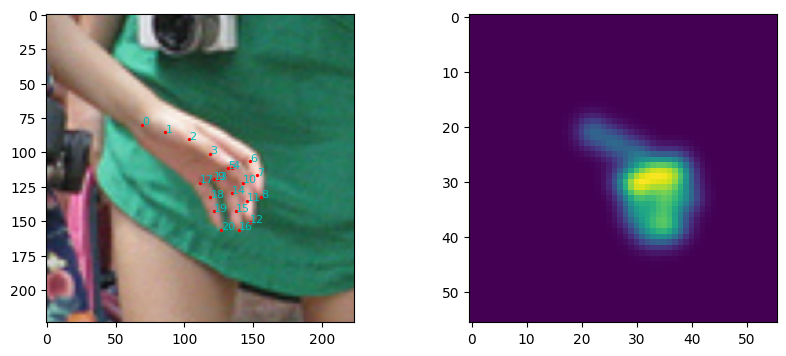

In [3]:
##############
rand_idx = 42
##############

# Get 1st image data
input, target, target_weight, meta = valid_dataset[rand_idx]
print(input.shape)

# Original image
plt.figure(figsize=(10,6))
orig_img = np.array(Image.open(meta['image']))
plt.imshow(orig_img)
plt.scatter(valid_dataset.db[rand_idx]['joints_3d'][:,0], valid_dataset.db[rand_idx]['joints_3d'][:,1], color='r', s=2)

# Visualization
# vis_input = inv_normalize(input).permute(1,2,0).numpy()[:,:,::-1]
vis_input = input[:,:,::-1].copy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(vis_input)
plt.scatter(meta['joints'][:,0], meta['joints'][:,1], color='r', s=2)
for i in range(21):
    plt.text(meta['joints'][i,0], meta['joints'][i,1], str(i), color='c', fontsize=8)

plt.subplot(1,2,2)
plt.imshow(target.sum(0))

(-0.5, 223.5, 223.5, -0.5)

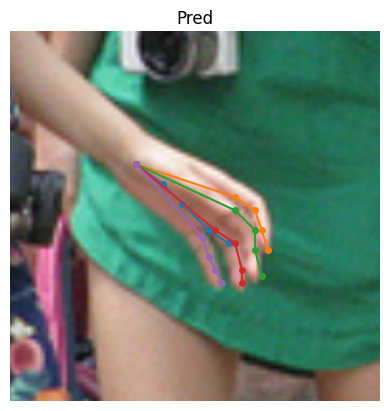

In [7]:
hand_index = np.array([[0,1,2,3,4],
                        [0,5,6,7,8],
                        [0,9,10,11,12],
                        [0,13,14,15,16],
                        [0,17,18,19,20]])
frei_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3950, 0.4323, 0.2954],
                         std=[0.1964, 0.1734, 0.1831])
])

# Inference of pretrained POTTER on COCOWholebody-Hand dataset
input_potter_demo = frei_transform(vis_input.copy())

# Inference
output = model(input_potter_demo.unsqueeze(0))
preds, _ = get_max_preds(output.detach().cpu().numpy())
pred_kpts = preds.squeeze() * 4
plt.figure()
plt.imshow(vis_input);
for finger_index in hand_index:
    curr_finger_kpts = pred_kpts[finger_index]
    plt.plot(curr_finger_kpts[:,0], curr_finger_kpts[:,1], marker='o', markersize=4)
plt.title('Pred')
plt.axis('off')